In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython

%run /gfs/devel/ddanko/notebook-init.py

# load R libraries                                                                                    
%R invisible(library(ggplot2))
%R invisible(library(fastcluster))
%R invisible(library(reshape))
%R invisible(library(reshape2))
%R invisible(library(gplots))
%R invisible(library(RSQLite))

#set up ggplot2 defaults                                                                              
%R theme_set(theme_gray(base_size=18))

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)


Populating the interactive namespace from numpy and matplotlib


In [2]:
%%R
prettyname <- function(ugly){
    names = c(
        'gpigfecal.dna', 
        'filtered.stool.day0',  
        'filtered.stool.day14', 
        'rumen.rnalow',         
        'rumen.rnahigh',
        'cowrumen.dna',
        'human.anterior.nares',
        'human.stool',
        'human.posterior.fornix',
        'human.throat',
        'human.qin.CD',
        'human.qin.HEALTHY',
        'human.qin.UC'

    )

    classes = c(
        'Guinea Pig Stool DNA',
        'Healthy Mouse Stool RNA',
        'Colitic Mouse Stool RNA',
        'Sheep Rumen, low-methane prod. RNA',
        'Sheep Rumen, high-methane prod. RNA',
        'Cow Rumen DNA',
        'HMP Anterior Nares DNA',
        'HMP Stool DNA',
        'HMP Posterior Fornix DNA',
        'HMP Throat DNA',
        'CD Human Stool, Qin et al DNA',
        'Healthy Human Stool, Qin et al DNA',
        'UC Human Stool, Qin et al DNA'
    )
    
    ougly <- ugly
    ugly <- strsplit(ugly,c("[\\_\\.\\-]"),fixed=F)[[1]]

    
    i <- 1
    for (name in names){
    
        
        name <- strsplit(name,c("[\\_\\.\\-]"),fixed=F)[[1]]

        if( all(ugly==name)){
            return( classes[i])
        } 
        i <- i+1
    }
    return(ougly)
    
}

print(prettyname("gpigfecal.dna"))
print(prettyname("human.posterior_fornix"))
print(prettyname("cowrumen.dna"))
print(prettyname("human.anterior_nares"))


[1] "Guinea Pig Stool DNA"
[1] "HMP Posterior Fornix DNA"
[1] "Cow Rumen DNA"
[1] "HMP Anterior Nares DNA"


[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/kraken.dir/species.kraken.aggregated.counts.tsv.gz"  
[2] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/kraken.dir/species.kraken.aggregated.counts.tsv.gz"      
[3] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/human/kraken.dir/species.kraken.aggregated.counts.tsv.gz"      
[4] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/sheep_rumen/kraken.dir/species.kraken.aggregated.counts.tsv.gz"
 [1] Cow Rumen DNA                       Cow Rumen DNA                      
 [3] Cow Rumen DNA                       Cow Rumen DNA                      
 [5] Cow Rumen DNA                       Cow Rumen DNA                      
 [7] Cow Rumen DNA                       Cow Rumen DNA                      
 [9] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
[11] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
[13] Guine

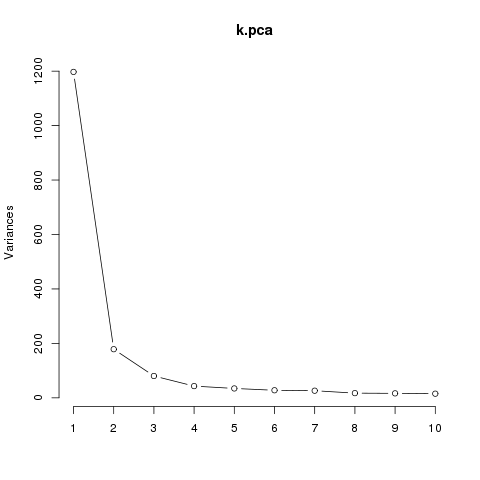

In [387]:
%%R

##########################################################
##########################################################
#
# KRAKEN
#
##########################################################
##########################################################


tableNames <- Sys.glob('/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/*/kraken.dir/species.kraken.aggregated.counts.tsv.gz')
print(tableNames)

k.classes <- c()
kraken <- matrix(0,0,0)
for (tbl in tableNames){
    tbl <- read.table(tbl,header=T,blank.lines.skip=T,sep="\t",row.names=1)
    classesInTbl <- lapply(colnames(tbl),function(n){prettyname(strsplit(n,'\\.R')[[1]][1])})
    
    tbl[is.na(tbl)] <- 0
    tbl <- data.matrix(tbl)
    tbl <- sweep(tbl,2,colSums(tbl),function(el,n){ log2(1000000*el/n)})
    tbl <- apply(tbl,1:2,max,0)
    #tbl <- tbl[apply(tbl, 1, function(row) any(row !=0 )),]

    k.classes <- c(k.classes,  unlist(classesInTbl))
    kraken <- merge(kraken,tbl,by="row.names",all=T)
    kraken[is.na(kraken)] <- 0 
    rownames(kraken) <- kraken[,1]
    kraken <- kraken[,-1]
}
k.classes <- as.factor(k.classes)
print(k.classes)
print(kraken[1:2,1:4])
kraken <- kraken[apply(kraken, 1, function(row) any(row !=0 )),]

k.pca <- prcomp(t(kraken),center=T,scale=T)
plot(k.pca,type='l')

[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983262.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983263.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983264.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983265.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983266.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983267.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R983268.mp2prof.tsv"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/metaphlan2.dir/cowrumen-dna-R9832

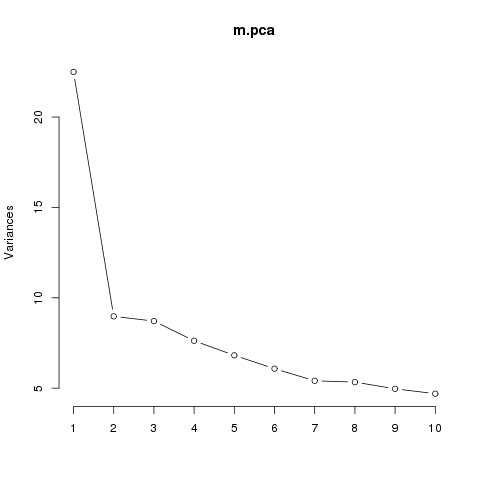

In [368]:
%%R

##########################################################
##########################################################
#
# METAPHLAN2
#
##########################################################
##########################################################

tableNames <- Sys.glob('/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/*/metaphlan2.dir/*.mp2prof.tsv')

m.classes <- c()
mphlan <- matrix(0,0,0)

getTable <- function(tblName){
    out <- tryCatch(
        {
            tbl <- read.table(tblName,blank.lines.skip=T,sep="\t",row.names=1)
            return(tbl)
        },
        error=function(cond){
            return(FALSE)
        },
        warning=function(cond){
            return(FALSE)
        },
        finally={
            
        }
    )
    return(out)
}


for (tblName in tableNames){
    print(tblName)
    tbl <- getTable(tblName)
    if(!tbl){
        next
    }


    class <- prettyname(tail(strsplit(strsplit(tblName,'-R')[[1]][1],'/')[[1]],1))
    sample <- tail(strsplit(strsplit(tblName,'\\.mp2')[[1]][1],'/')[[1]],1)
    genera <- rownames(tbl)[grep('g__',rownames(tbl))]
    genera <- genera[grep('s__',genera,invert=T)]
    tbl <-tbl[rownames(tbl) %in% genera,,drop=F]
    m.classes <- c(m.classes,class)
    newcolnames <- c(colnames(mphlan),sample)
    mphlan <- merge(mphlan,tbl,by="row.names",all=T)
    mphlan[is.na(mphlan)] <- 0
    rownames(mphlan) <- mphlan[,1]
    mphlan <- mphlan[,-1,drop=F]
    colnames(mphlan) <- newcolnames
}
m.classes <- factor(m.classes)
print(m.classes)
print(mphlan[1:5,1:4])

m.pca <- prcomp(t(mphlan),center=T,scale=T)
plot(m.pca,type='l')





In [5]:
%%R

##########################################################
##########################################################
#
# AC-DIAMOND
#
##########################################################
##########################################################

tableNames <- Sys.glob('/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/*/*dmnd.dir/species.*dmnd.aggregated.counts.tsv.gz')
print(tableNames)
tableNames2 <- Sys.glob('/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/*/*dmnd.dir/*dmnd.species.counts.tsv.gz')
print(tableNames2)

ad.classes <- c()
acdmnd <- matrix(0,0,0)
for (tbl in tableNames){
    tbl <- read.table(tbl,header=T,blank.lines.skip=T,sep="\t",row.names=1)
    classesInTbl <- lapply(colnames(tbl),function(n){prettyprint(strsplit(n,'\\.R')[[1]][1])})
    
    class <- tail(strsplit(strsplit(tblName,'-R')[[1]][1],'/')[[1]],1)
    sample <- tail(strsplit(strsplit(tblName,'\\.acdmnd.species')[[1]][1],'/')[[1]],1)
    
    tbl[is.na(tbl)] <- 0
    tbl <- data.matrix(tbl)
    tbl <- sweep(tbl,2,colSums(tbl),function(el,n){ log2(1000000*el/n)})
    tbl <- apply(tbl,1:2,max,0)
    #tbl <- tbl[apply(tbl, 1, function(row) any(row !=0 )),]
        
    ad.classes <- c(ad.classes,  unlist(classesInTbl))
        
    acdmnd <- merge(acdmnd,tbl,by="row.names",all=T)
    acdmnd[is.na(acdmnd)] <- 0 

    rownames(acdmnd) <- acdmnd[,1]
    acdmnd <- acdmnd[,-1]
}
ad.classes <- factor(ad.classes)
print(ad.classes)

print(length(ad.classes))
print(dim(acdmnd))
print(acdmnd[1:5,1:4])
acdmnd <- acdmnd[apply(acdmnd, 1, function(row) any(row !=0 )),]                     
ad.pca <- prcomp(t(acdmnd),center=T,scale=T)
plot(ad.pca,type='l')


[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmnd.dir/species.acdmnd.aggregated.counts.tsv.gz"    
[2] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/human_qin/acdmnd.dir/species.acdmnd.aggregated.counts.tsv.gz"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmnd.dir/gpigfecal-dna-R495409.acdmnd.species.counts.tsv.gz"
[2] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmnd.dir/gpigfecal-dna-R496625.acdmnd.species.counts.tsv.gz"
[3] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmnd.dir/gpigfecal-dna-R496626.acdmnd.species.counts.tsv.gz"
[4] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmnd.dir/gpigfecal-dna-R496699.acdmnd.species.counts.tsv.gz"
[5] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmnd.dir/gpigfecal-dna-R496700.acdmnd.species.counts.tsv.gz"
[6] "/gfs/work/ddanko/taxonomic_profiler_comparison/ana

[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/dmndfast.dir/species.dmndfast.aggregated.counts.tsv.gz"      
[2] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmndfast.dir/species.acdmndfast.aggregated.counts.tsv.gz"      
[3] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/human_qin/acdmndfast.dir/species.acdmndfast.aggregated.counts.tsv.gz"  
[4] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/mouse/acdmndfast.dir/species.acdmndfast.aggregated.counts.tsv.gz"      
[5] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/sheep_rumen/acdmndfast.dir/species.acdmndfast.aggregated.counts.tsv.gz"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/cow_rumen/dmndfast.dir/species.dmndfast.aggregated.counts.tsv.gz"
[1] "/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/g_pig/acdmndfast.dir/species.acdmndfast.aggregated.counts.tsv.gz"
[1] "/gfs/work/ddanko/taxonomic_

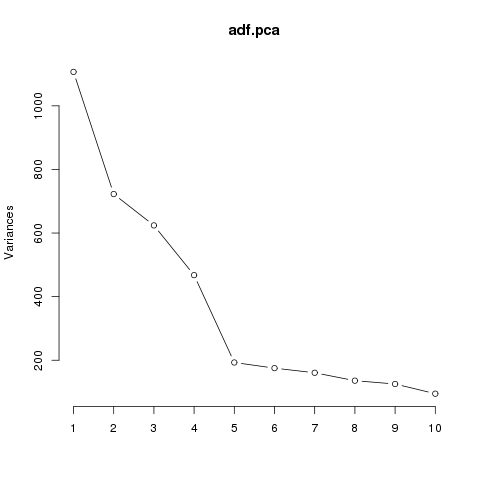

In [371]:

%%R

##########################################################
##########################################################
#
# AC-DIAMOND FAST
#
##########################################################
##########################################################

tableNames <- Sys.glob('/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/*/*dmndfast.dir/species.*dmndfast.aggregated.counts.tsv.gz')
print(tableNames)

adf.classes <- c()
acdmndfast <- matrix(0,0,0)
for (tbl in tableNames){
    print(tbl)
    tbl <- read.table(tbl,header=T,blank.lines.skip=T,sep="\t",row.names=1)
    classesInTbl <- lapply(colnames(tbl),function(n){prettyname(strsplit(n,'\\.R')[[1]][1])})

    tbl[is.na(tbl)] <- 0
    tbl <- data.matrix(tbl)
    tbl <- sweep(tbl,2,colSums(tbl),function(el,n){ log2(1000000*el/n)})
    tbl <- apply(tbl,1:2,max,0)
    #tbl <- tbl[apply(tbl, 1, function(row) any(row !=0 )),]

    adf.classes <- c(adf.classes,  unlist(classesInTbl))
    acdmndfast <- merge(acdmndfast,tbl,by="row.names",all=T)
    acdmndfast[is.na(acdmndfast)] <- 0 

    rownames(acdmndfast) <- acdmndfast[,1]
    acdmndfast <- acdmndfast[,-1]
}
adf.classes <- factor(adf.classes)
print(adf.classes)
acdmndfast <- acdmndfast[apply(acdmndfast, 1, function(row) any(row !=0 )),]  
    
print(length(adf.classes))
print(dim(acdmndfast))
print(acdmndfast[1:5,1:4])
            

adf.pca <- prcomp(t(acdmndfast),center=T,scale=T)
plot(adf.pca,type='l')                    


In [7]:
%%R

##########################################################
##########################################################
#
# AC-DIAMOND FAST (ALTERNATE)
#
##########################################################
##########################################################
# print("AC-DIAMOND FAST (ALTERNATE)")
# tableNames <- Sys.glob('/gfs/work/ddanko/taxonomic_profiler_comparison/analysis/actual/*/*dmndfast.dir/*dmndfast.species.counts.tsv.gz')
# print(tableNames)
# #tableNames <- tableNames[1:3]


# adf2.classes <- c()
# acdmndfast2 <- matrix(0,0,0)
# for (tblName in tableNames){
#     tbl <- read.table(tblName,header=T,blank.lines.skip=T,sep="\t",row.names=1)
#     #print(head(tbl))
#     #classesInTbl <- lapply(colnames(tbl),function(n){strsplit(n,'\\.R')[[1]][1]})
    
#     class <- tail(strsplit(strsplit(tblName,'-R')[[1]][1],'/')[[1]],1)
#     sample <- tail(strsplit(strsplit(tblName,'\\.acdmndfast.species')[[1]][1],'/')[[1]],1)

#     tbl[is.na(tbl)] <- 0
#     tbl <- data.matrix(tbl)
#     tbl <- sweep(tbl,2,colSums(tbl),function(el,n){ log2(1000000*el/n)})
#     tbl <- apply(tbl,1:2,max,0)
#     #tbl <- tbl[apply(tbl, 1, function(row) any(row !=0 )),]
        
#     adf2.classes <- c(adf2.classes,  class)
#     newcolnames <- c( colnames(acdmndfast2), sample)
#     #print(head(acdmndfast))
#     acdmndfast2 <- merge(acdmndfast2,tbl,by="row.names",all=T)
#     print('*')
#     print(dim(acdmndfast2))
#     #print(head(acdmndfast))
#     acdmndfast2[is.na(acdmndfast2)] <- 0 


#     rownames(acdmndfast2) <- acdmndfast2[,1]
#     acdmndfast2 <- acdmndfast2[,-1,drop=F]
#     colnames(acdmndfast2) <- newcolnames
# }
# adf2.classes <- factor(adf2.classes)
# print(adf2.classes)

# acdmndfast2 <- acdmndfast2[apply(acdmndfast2, 1, function(row) any(row !=0 )),]  
    
# print(length(adf2.classes))
# print(dim(acdmndfast2))
# print(acdmndfast2[1:5,1:3])
               
# adf2.pca <- prcomp(t(acdmndfast2),center=T,scale=T)
# plot(adf2.pca,type='l')


NULL


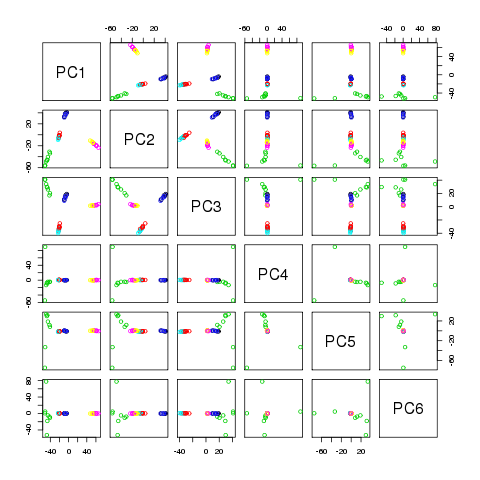

In [8]:
%%R
library(ggplot2)

#pairs(adf.pca$x[,1:6],pch=21,bg=rainbow(length(unique(adf.classes)))[unclass(adf.classes)])
pairs(adf.pca$x[,1:6],pch=21,col=adf.classes)


In [25]:
%%R

##########################################################
##########################################################
#
# PCA Plots
#
##########################################################
##########################################################

library(ggplot2)
library(gridExtra)
library(factoextra)

plotPCA <- function(comps, pca, classes){
    
#     df <- data.frame(pca$x)
#     df[,"class"] <- classes 
#     combs <- combn(comps,2,simplify=F)

#     for (comb in combs){

#         p <- fviz_pca_ind(pca, axes=comb, geom = "point",
#                     habillage=classes, addEllipses=TRUE,
#                     ellipse.level= 0.95)+ theme_minimal()
#                 print(p) 
        
#     }
        df <- data.frame(pca$x)
        df['Groups'] = classes
        combs <- combn(comps,2,simplify=F)
        for (comb in combs){
            X = colnames(df)[comb[1]]
            Y = colnames(df)[comb[2]]
            p <- ggplot(df,aes_string(x=X,y=Y, color="Groups")) +
                    geom_point(size=4) +
                    scale_shape_manual(values=c(3,16,17)) +
                    stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="Groups")) +
                    theme_minimal()
            print(p)
        }

}


In [23]:
%%R

##########################################################
##########################################################
#
# ICA Plots
#
##########################################################
##########################################################

library(ggplot2)
library(gridExtra)
library(factoextra)

plotICA <- function(ica, classes){
    
    df <- data.frame(ica$S)
    df['Groups'] = classes
    combs <- combn(1:dim(ica$S)[2],2,simplify=F)
    for (comb in combs){
        X = colnames(df)[comb[1]]
        Y = colnames(df)[comb[2]]
        p <- ggplot(df,aes_string(x=X,y=Y, color="Groups")) +
                geom_point(size=4) +
                stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="Groups")) +
                theme_minimal()
        print(p)
    }
}


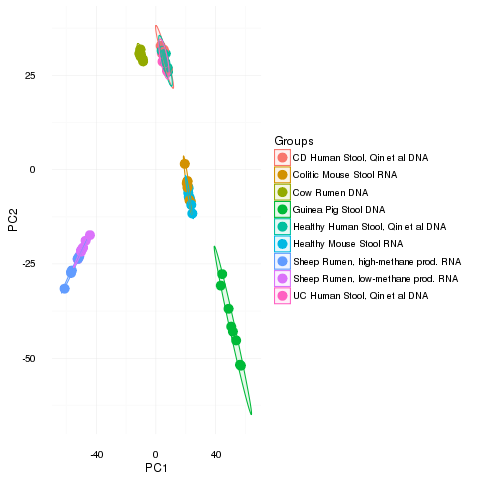

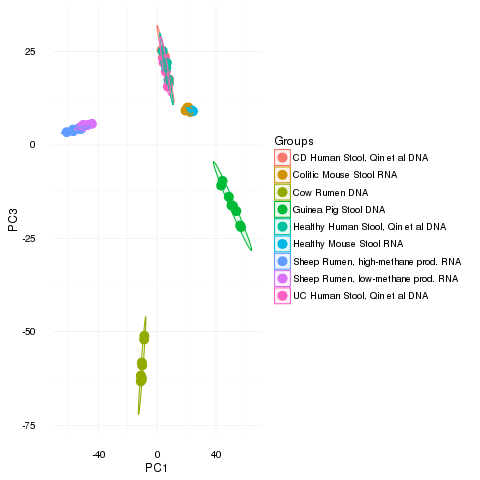

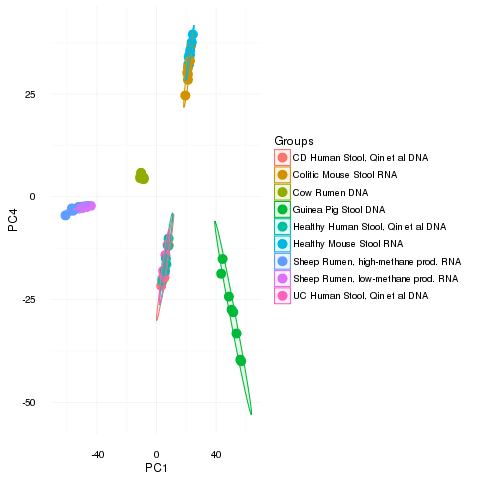

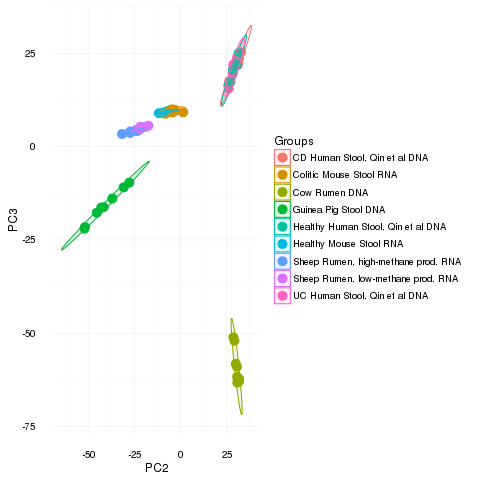

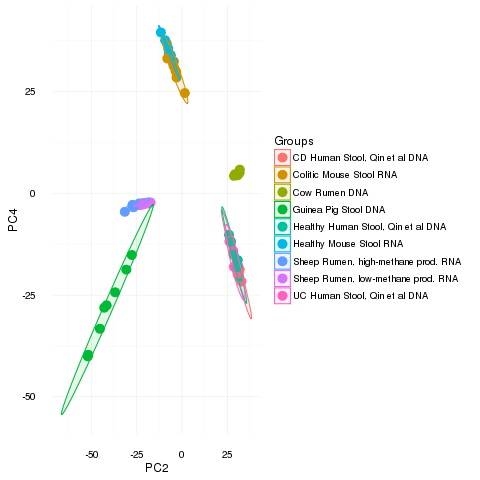

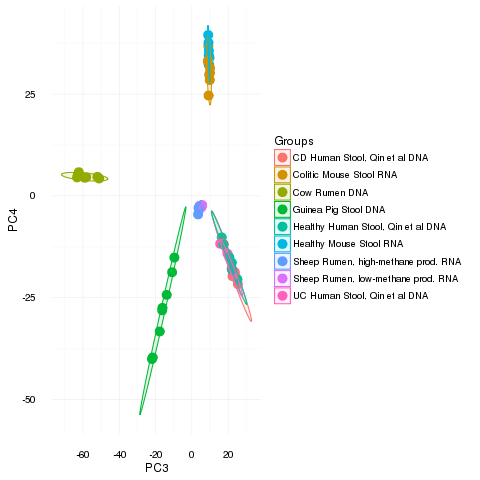

In [372]:
%%R

plotPCA(1:4, adf.pca, adf.classes)

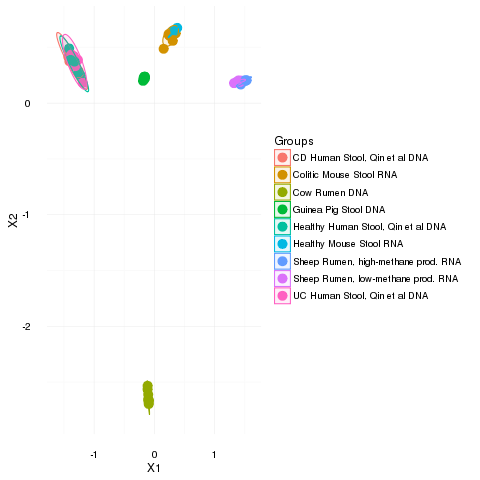

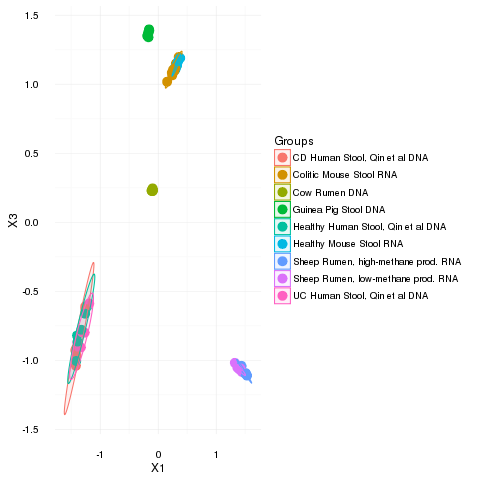

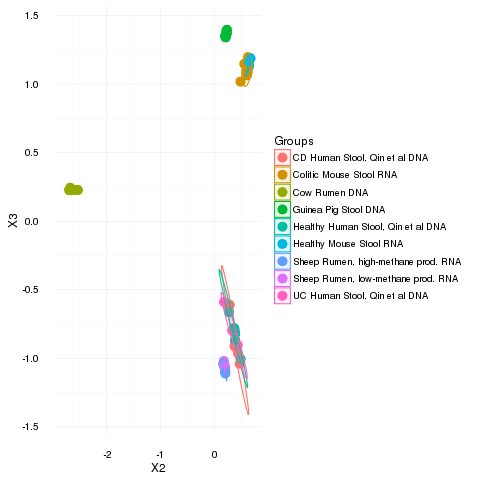

In [373]:
%%R

library(fastICA)
adf.ica <- fastICA(t(acdmndfast),3)
plotICA(adf.ica,adf.classes)

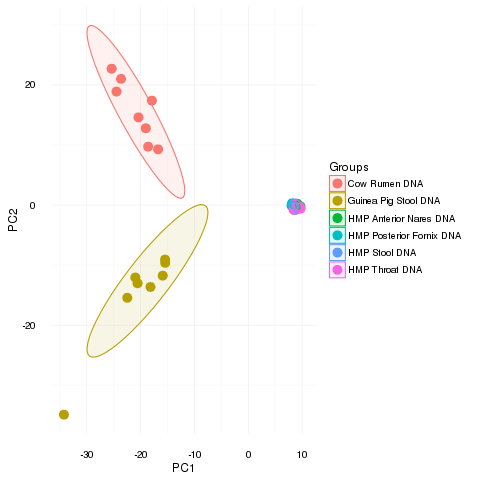

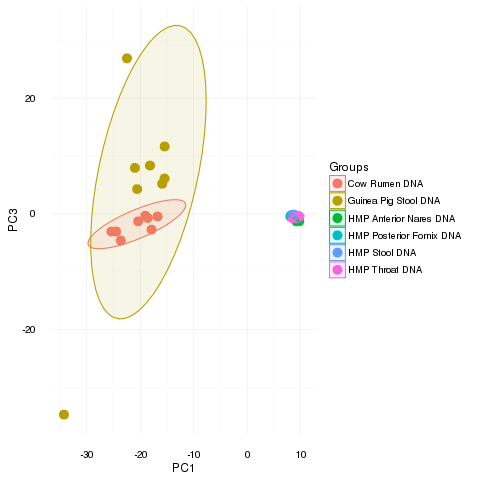

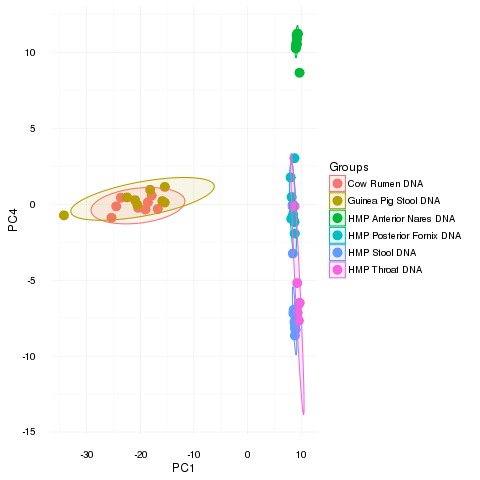

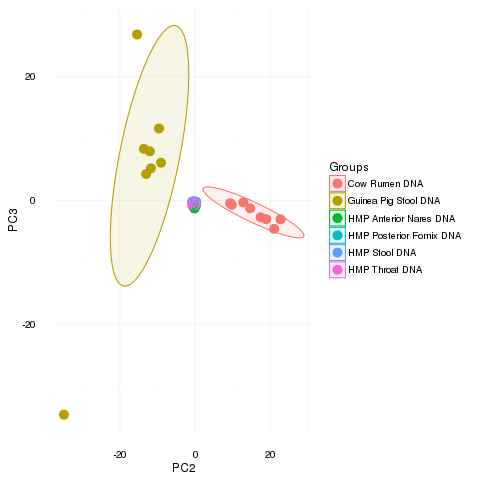

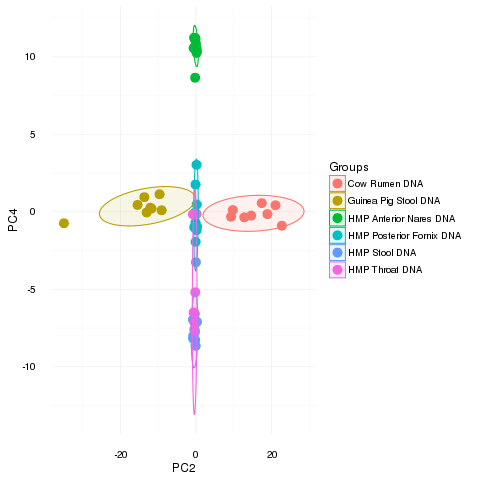

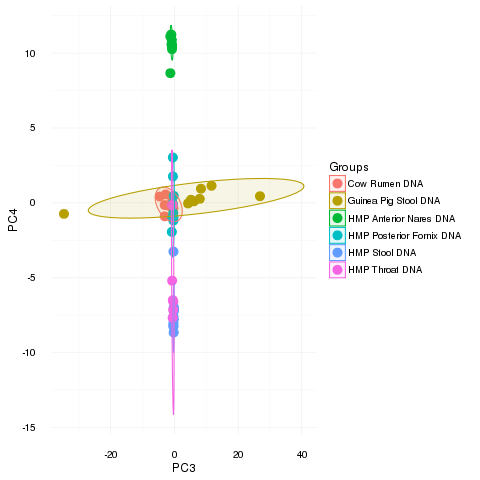

In [374]:
%%R
plotPCA(1:4, k.pca, k.classes)

In [375]:
%%R

plotPCA(1:3, ad.pca, ad.classes)


Error in data.frame(pca$x) : object 'ad.pca' not found


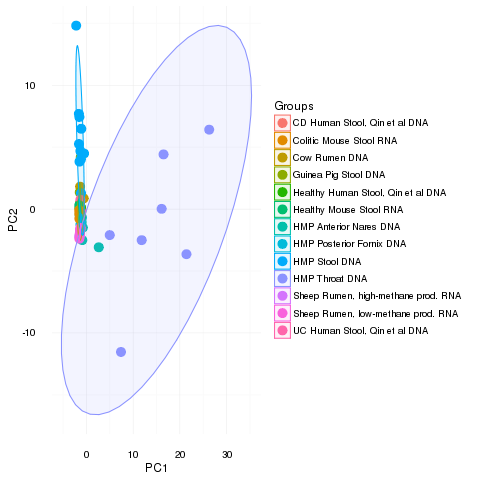

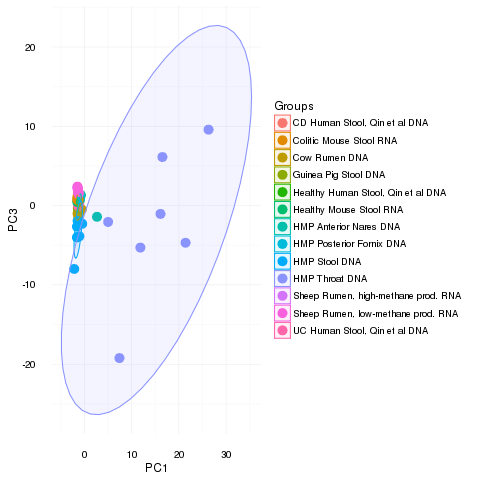

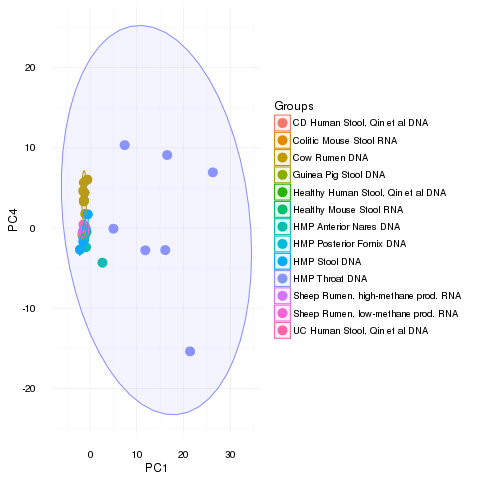

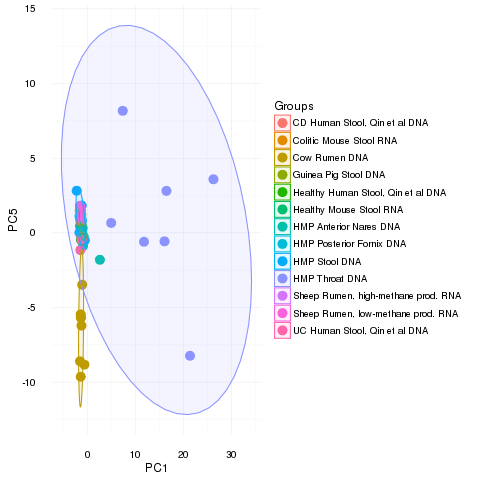

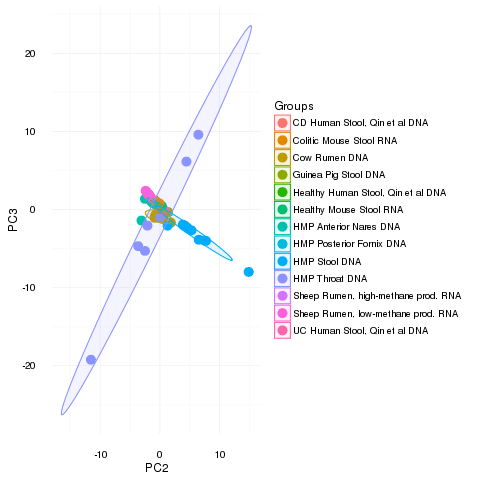

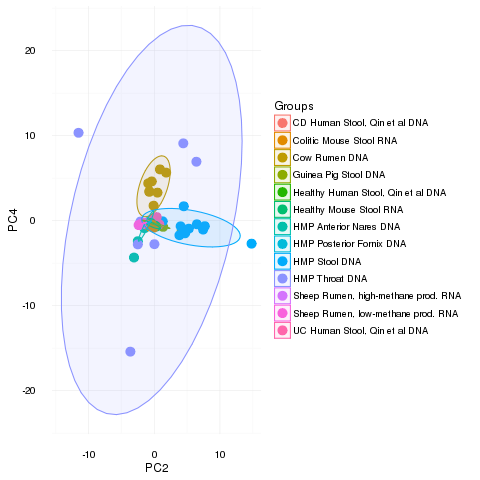

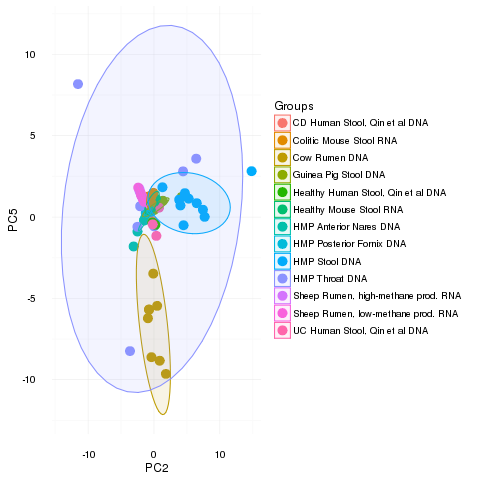

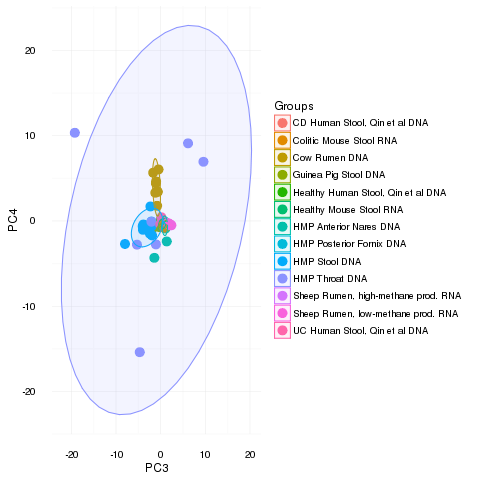

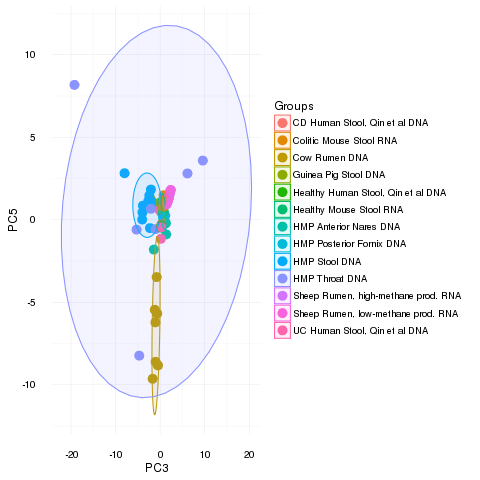

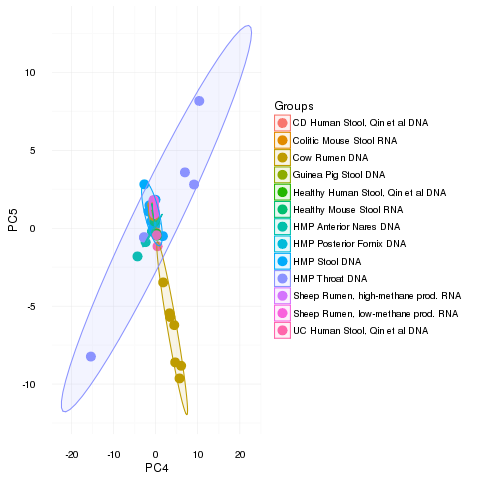

In [376]:
%%R
plotPCA(1:5, m.pca, m.classes)

In [377]:
%%R


make_jsd_matrix <- function(n){

    m <- matrix(nrow=ncol(n),ncol=ncol(n))

    for (i in 1:ncol(n)){
        for (j in 1:ncol(n)){
            m[i,j] <- jsd(n[,i],n[,j])
        }
     }
    colnames(m) <- colnames(n)
     rownames(m) <- colnames(n)
     return(m)
}

jsd <- function(a,b){
    anorm <- a/sum(a)
    bnorm <- b/sum(b)
     m <- (anorm+bnorm)/2
     div <- kld(anorm,m)/2 + kld(bnorm,m)/2
     dist <- sqrt(div)
     return(dist) 
}

kld <- function(a,b){
     l <- log(a/b, 2)
     l[is.na(l)] <- 0
     l[is.infinite(l)] <- 0

    return( sum( a * l))
}



In [378]:
%%R 

adf.jdm <- make_jsd_matrix(acdmndfast)


In [379]:
%%R

install.packages("devtools")



The downloaded source packages are in
	‘/tmp/RtmpO1kJkn/downloaded_packages’


In [380]:
%%R

library(devtools)
library(gplots)

heatmap.3 <- function(x,
                      Rowv = TRUE, Colv = if (symm) "Rowv" else TRUE,
                      distfun = dist,
                      hclustfun = hclust,
                      dendrogram = c("both","row", "column", "none"),
                      symm = FALSE,
                      scale = c("none","row", "column"),
                      na.rm = TRUE,
                      revC = identical(Colv,"Rowv"),
                      add.expr,
                      breaks,
                      symbreaks = max(x < 0, na.rm = TRUE) || scale != "none",
                      col = "heat.colors",
                      colsep,
                      rowsep,
                      sepcolor = "white",
                      sepwidth = c(0.05, 0.05),
                      cellnote,
                      notecex = 1,
                      notecol = "cyan",
                      na.color = par("bg"),
                      trace = c("none", "column","row", "both"),
                      tracecol = "cyan",
                      hline = median(breaks),
                      vline = median(breaks),
                      linecol = tracecol,
                      margins = c(5,5),
                      ColSideColors,
                      RowSideColors,
                      side.height.fraction=0.3,
                      cexRow = 0.2 + 1/log10(nr),
                      cexCol = 0.2 + 1/log10(nc),
                      labRow = NULL,
                      labCol = NULL,
                      key = TRUE,
                      keysize = 1.5,
                      density.info = c("none", "histogram", "density"),
                      denscol = tracecol,
                      symkey = max(x < 0, na.rm = TRUE) || symbreaks,
                      densadj = 0.25,
                      main = NULL,
                      xlab = NULL,
                      ylab = NULL,
                      lmat = NULL,
                      lhei = NULL,
                      lwid = NULL,
                      ColSideColorsSize = 1,
                      RowSideColorsSize = 1,
                      KeyValueName="Value",...){
 
    invalid <- function (x) {
      if (missing(x) || is.null(x) || length(x) == 0)
          return(TRUE)
      if (is.list(x))
          return(all(sapply(x, invalid)))
      else if (is.vector(x))
          return(all(is.na(x)))
      else return(FALSE)
    }
 
    x <- as.matrix(x)
    scale01 <- function(x, low = min(x), high = max(x)) {
        x <- (x - low)/(high - low)
        x
    }
    retval <- list()
    scale <- if (symm && missing(scale))
        "none"
    else match.arg(scale)
    dendrogram <- match.arg(dendrogram)
    trace <- match.arg(trace)
    density.info <- match.arg(density.info)
    if (length(col) == 1 && is.character(col))
        col <- get(col, mode = "function")
    if (!missing(breaks) && (scale != "none"))
        warning("Using scale=\"row\" or scale=\"column\" when breaks are",
            "specified can produce unpredictable results.", "Please consider using only one or the other.")
    if (is.null(Rowv) || is.na(Rowv))
        Rowv <- FALSE
    if (is.null(Colv) || is.na(Colv))
        Colv <- FALSE
    else if (Colv == "Rowv" && !isTRUE(Rowv))
        Colv <- FALSE
    if (length(di <- dim(x)) != 2 || !is.numeric(x))
        stop("`x' must be a numeric matrix")
    nr <- di[1]
    nc <- di[2]
    if (nr <= 1 || nc <= 1)
        stop("`x' must have at least 2 rows and 2 columns")
    if (!is.numeric(margins) || length(margins) != 2)
        stop("`margins' must be a numeric vector of length 2")
    if (missing(cellnote))
        cellnote <- matrix("", ncol = ncol(x), nrow = nrow(x))
    if (!inherits(Rowv, "dendrogram")) {
        if (((!isTRUE(Rowv)) || (is.null(Rowv))) && (dendrogram %in%
            c("both", "row"))) {
            if (is.logical(Colv) && (Colv))
                dendrogram <- "column"
            else dedrogram <- "none"
            warning("Discrepancy: Rowv is FALSE, while dendrogram is `",
                dendrogram, "'. Omitting row dendogram.")
        }
    }
    if (!inherits(Colv, "dendrogram")) {
        if (((!isTRUE(Colv)) || (is.null(Colv))) && (dendrogram %in%
            c("both", "column"))) {
            if (is.logical(Rowv) && (Rowv))
                dendrogram <- "row"
            else dendrogram <- "none"
            warning("Discrepancy: Colv is FALSE, while dendrogram is `",
                dendrogram, "'. Omitting column dendogram.")
        }
    }
    if (inherits(Rowv, "dendrogram")) {
        ddr <- Rowv
        rowInd <- order.dendrogram(ddr)
    }
    else if (is.integer(Rowv)) {
        hcr <- hclustfun(distfun(x))
        ddr <- as.dendrogram(hcr)
        ddr <- reorder(ddr, Rowv)
        rowInd <- order.dendrogram(ddr)
        if (nr != length(rowInd))
            stop("row dendrogram ordering gave index of wrong length")
    }
    else if (isTRUE(Rowv)) {
        Rowv <- rowMeans(x, na.rm = na.rm)
        hcr <- hclustfun(distfun(x))
        ddr <- as.dendrogram(hcr)
        ddr <- reorder(ddr, Rowv)
        rowInd <- order.dendrogram(ddr)
        if (nr != length(rowInd))
            stop("row dendrogram ordering gave index of wrong length")
    }
    else {
        rowInd <- nr:1
    }
    if (inherits(Colv, "dendrogram")) {
        ddc <- Colv
        colInd <- order.dendrogram(ddc)
    }
    else if (identical(Colv, "Rowv")) {
        if (nr != nc)
            stop("Colv = \"Rowv\" but nrow(x) != ncol(x)")
        if (exists("ddr")) {
            ddc <- ddr
            colInd <- order.dendrogram(ddc)
        }
        else colInd <- rowInd
    }
    else if (is.integer(Colv)) {
        hcc <- hclustfun(distfun(if (symm)
            x
        else t(x)))
        ddc <- as.dendrogram(hcc)
        ddc <- reorder(ddc, Colv)
        colInd <- order.dendrogram(ddc)
        if (nc != length(colInd))
            stop("column dendrogram ordering gave index of wrong length")
    }
    else if (isTRUE(Colv)) {
        Colv <- colMeans(x, na.rm = na.rm)
        hcc <- hclustfun(distfun(if (symm)
            x
        else t(x)))
        ddc <- as.dendrogram(hcc)
        ddc <- reorder(ddc, Colv)
        colInd <- order.dendrogram(ddc)
        if (nc != length(colInd))
            stop("column dendrogram ordering gave index of wrong length")
    }
    else {
        colInd <- 1:nc
    }
    retval$rowInd <- rowInd
    retval$colInd <- colInd
    retval$call <- match.call()
    x <- x[rowInd, colInd]
    x.unscaled <- x
    cellnote <- cellnote[rowInd, colInd]
    if (is.null(labRow))
        labRow <- if (is.null(rownames(x)))
            (1:nr)[rowInd]
        else rownames(x)
    else labRow <- labRow[rowInd]
    if (is.null(labCol))
        labCol <- if (is.null(colnames(x)))
            (1:nc)[colInd]
        else colnames(x)
    else labCol <- labCol[colInd]
    if (scale == "row") {
        retval$rowMeans <- rm <- rowMeans(x, na.rm = na.rm)
        x <- sweep(x, 1, rm)
        retval$rowSDs <- sx <- apply(x, 1, sd, na.rm = na.rm)
        x <- sweep(x, 1, sx, "/")
    }
    else if (scale == "column") {
        retval$colMeans <- rm <- colMeans(x, na.rm = na.rm)
        x <- sweep(x, 2, rm)
        retval$colSDs <- sx <- apply(x, 2, sd, na.rm = na.rm)
        x <- sweep(x, 2, sx, "/")
    }
    if (missing(breaks) || is.null(breaks) || length(breaks) < 1) {
        if (missing(col) || is.function(col))
            breaks <- 16
        else breaks <- length(col) + 1
    }
    if (length(breaks) == 1) {
        if (!symbreaks)
            breaks <- seq(min(x, na.rm = na.rm), max(x, na.rm = na.rm),
                length = breaks)
        else {
            extreme <- max(abs(x), na.rm = TRUE)
            breaks <- seq(-extreme, extreme, length = breaks)
        }
    }
    nbr <- length(breaks)
    ncol <- length(breaks) - 1
    if (class(col) == "function")
        col <- col(ncol)
    min.breaks <- min(breaks)
    max.breaks <- max(breaks)
    x[x < min.breaks] <- min.breaks
    x[x > max.breaks] <- max.breaks
    if (missing(lhei) || is.null(lhei))
        lhei <- c(keysize, 4)
    if (missing(lwid) || is.null(lwid))
        lwid <- c(keysize, 4)
    if (missing(lmat) || is.null(lmat)) {
        lmat <- rbind(4:3, 2:1)
 
        if (!missing(ColSideColors)) {
           #if (!is.matrix(ColSideColors))
           #stop("'ColSideColors' must be a matrix")
            if (!is.character(ColSideColors) || nrow(ColSideColors) != nc)
                stop("'ColSideColors' must be a matrix of nrow(x) rows")
            lmat <- rbind(lmat[1, ] + 1, c(NA, 1), lmat[2, ] + 1)
            #lhei <- c(lhei[1], 0.2, lhei[2])
             lhei=c(lhei[1], side.height.fraction*ColSideColorsSize/2, lhei[2])
        }
 
        if (!missing(RowSideColors)) {
            #if (!is.matrix(RowSideColors))
            #stop("'RowSideColors' must be a matrix")
            if (!is.character(RowSideColors) || ncol(RowSideColors) != nr)
                stop("'RowSideColors' must be a matrix of ncol(x) columns")
            lmat <- cbind(lmat[, 1] + 1, c(rep(NA, nrow(lmat) - 1), 1), lmat[,2] + 1)
            #lwid <- c(lwid[1], 0.2, lwid[2])
            lwid <- c(lwid[1], side.height.fraction*RowSideColorsSize/2, lwid[2])
        }
        lmat[is.na(lmat)] <- 0
    }
 
    if (length(lhei) != nrow(lmat))
        stop("lhei must have length = nrow(lmat) = ", nrow(lmat))
    if (length(lwid) != ncol(lmat))
        stop("lwid must have length = ncol(lmat) =", ncol(lmat))
    op <- par(no.readonly = TRUE)
    on.exit(par(op))
 
    layout(lmat, widths = lwid, heights = lhei, respect = FALSE)
 
    if (!missing(RowSideColors)) {
        if (!is.matrix(RowSideColors)){
                par(mar = c(margins[1], 0, 0, 0.5))
                image(rbind(1:nr), col = RowSideColors[rowInd], axes = FALSE)
        } else {
            par(mar = c(margins[1], 0, 0, 0.5))
            rsc = t(RowSideColors[,rowInd, drop=F])
            rsc.colors = matrix()
            rsc.names = names(table(rsc))
            rsc.i = 1
            for (rsc.name in rsc.names) {
                rsc.colors[rsc.i] = rsc.name
                rsc[rsc == rsc.name] = rsc.i
                rsc.i = rsc.i + 1
            }
            rsc = matrix(as.numeric(rsc), nrow = dim(rsc)[1])
            image(t(rsc), col = as.vector(rsc.colors), axes = FALSE)
            if (length(rownames(RowSideColors)) > 0) {
                axis(1, 0:(dim(rsc)[2] - 1)/max(1,(dim(rsc)[2] - 1)), rownames(RowSideColors), las = 2, tick = FALSE)
            }
        }
    }
 
    if (!missing(ColSideColors)) {
 
        if (!is.matrix(ColSideColors)){
            par(mar = c(0.5, 0, 0, margins[2]))
            image(cbind(1:nc), col = ColSideColors[colInd], axes = FALSE)
        } else {
            par(mar = c(0.5, 0, 0, margins[2]))
            csc = ColSideColors[colInd, , drop=F]
            csc.colors = matrix()
            csc.names = names(table(csc))
            csc.i = 1
            for (csc.name in csc.names) {
                csc.colors[csc.i] = csc.name
                csc[csc == csc.name] = csc.i
                csc.i = csc.i + 1
            }
            csc = matrix(as.numeric(csc), nrow = dim(csc)[1])
            image(csc, col = as.vector(csc.colors), axes = FALSE)
            if (length(colnames(ColSideColors)) > 0) {
                axis(2, 0:(dim(csc)[2] - 1)/max(1,(dim(csc)[2] - 1)), colnames(ColSideColors), las = 2, tick = FALSE)
            }
        }
    }
 
    par(mar = c(margins[1], 0, 0, margins[2]))
    x <- t(x)
    cellnote <- t(cellnote)
    if (revC) {
        iy <- nr:1
        if (exists("ddr"))
            ddr <- rev(ddr)
        x <- x[, iy]
        cellnote <- cellnote[, iy]
    }
    else iy <- 1:nr
    image(1:nc, 1:nr, x, xlim = 0.5 + c(0, nc), ylim = 0.5 + c(0, nr), axes = FALSE, xlab = "", ylab = "", col = col, breaks = breaks, ...)
    retval$carpet <- x
    if (exists("ddr"))
        retval$rowDendrogram <- ddr
    if (exists("ddc"))
        retval$colDendrogram <- ddc
    retval$breaks <- breaks
    retval$col <- col
    if (!invalid(na.color) & any(is.na(x))) { # load library(gplots)
        mmat <- ifelse(is.na(x), 1, NA)
        image(1:nc, 1:nr, mmat, axes = FALSE, xlab = "", ylab = "",
            col = na.color, add = TRUE)
    }
    axis(1, 1:nc, labels = labCol, las = 2, line = -0.5, tick = 0,
        cex.axis = cexCol)
    if (!is.null(xlab))
        mtext(xlab, side = 1, line = margins[1] - 1.25)
    axis(4, iy, labels = labRow, las = 2, line = -0.5, tick = 0,
        cex.axis = cexRow)
    if (!is.null(ylab))
        mtext(ylab, side = 4, line = margins[2] - 1.25)
    if (!missing(add.expr))
        eval(substitute(add.expr))
    if (!missing(colsep))
        for (csep in colsep) rect(xleft = csep + 0.5, ybottom = rep(0, length(csep)), xright = csep + 0.5 + sepwidth[1], ytop = rep(ncol(x) + 1, csep), lty = 1, lwd = 1, col = sepcolor, border = sepcolor)
    if (!missing(rowsep))
        for (rsep in rowsep) rect(xleft = 0, ybottom = (ncol(x) + 1 - rsep) - 0.5, xright = nrow(x) + 1, ytop = (ncol(x) + 1 - rsep) - 0.5 - sepwidth[2], lty = 1, lwd = 1, col = sepcolor, border = sepcolor)
    min.scale <- min(breaks)
    max.scale <- max(breaks)
    x.scaled <- scale01(t(x), min.scale, max.scale)
    if (trace %in% c("both", "column")) {
        retval$vline <- vline
        vline.vals <- scale01(vline, min.scale, max.scale)
        for (i in colInd) {
            if (!is.null(vline)) {
                abline(v = i - 0.5 + vline.vals, col = linecol,
                  lty = 2)
            }
            xv <- rep(i, nrow(x.scaled)) + x.scaled[, i] - 0.5
            xv <- c(xv[1], xv)
            yv <- 1:length(xv) - 0.5
            lines(x = xv, y = yv, lwd = 1, col = tracecol, type = "s")
        }
    }
    if (trace %in% c("both", "row")) {
        retval$hline <- hline
        hline.vals <- scale01(hline, min.scale, max.scale)
        for (i in rowInd) {
            if (!is.null(hline)) {
                abline(h = i + hline, col = linecol, lty = 2)
            }
            yv <- rep(i, ncol(x.scaled)) + x.scaled[i, ] - 0.5
            yv <- rev(c(yv[1], yv))
            xv <- length(yv):1 - 0.5
            lines(x = xv, y = yv, lwd = 1, col = tracecol, type = "s")
        }
    }
    if (!missing(cellnote))
        text(x = c(row(cellnote)), y = c(col(cellnote)), labels = c(cellnote),
            col = notecol, cex = notecex)
    par(mar = c(margins[1], 0, 0, 0))
    if (dendrogram %in% c("both", "row")) {
        plot(ddr, horiz = TRUE, axes = FALSE, yaxs = "i", leaflab = "none")
    }
    else plot.new()
    par(mar = c(0, 0, if (!is.null(main)) 5 else 0, margins[2]))
    if (dendrogram %in% c("both", "column")) {
        plot(ddc, axes = FALSE, xaxs = "i", leaflab = "none")
    }
    else plot.new()
    if (!is.null(main))
        title(main, cex.main = 1.5 * op[["cex.main"]])
    if (key) {
        par(mar = c(5, 4, 2, 1), cex = 0.75)
        tmpbreaks <- breaks
        if (symkey) {
            max.raw <- max(abs(c(x, breaks)), na.rm = TRUE)
            min.raw <- -max.raw
            tmpbreaks[1] <- -max(abs(x), na.rm = TRUE)
            tmpbreaks[length(tmpbreaks)] <- max(abs(x), na.rm = TRUE)
        }
        else {
            min.raw <- min(x, na.rm = TRUE)
            max.raw <- max(x, na.rm = TRUE)
        }
 
        z <- seq(min.raw, max.raw, length = length(col))
        image(z = matrix(z, ncol = 1), col = col, breaks = tmpbreaks,
            xaxt = "n", yaxt = "n")
        par(usr = c(0, 1, 0, 1))
        lv <- pretty(breaks)
        xv <- scale01(as.numeric(lv), min.raw, max.raw)
        axis(1, at = xv, labels = lv)
        if (scale == "row")
            mtext(side = 1, "Row Z-Score", line = 2)
        else if (scale == "column")
            mtext(side = 1, "Column Z-Score", line = 2)
        else mtext(side = 1, KeyValueName, line = 2)
        if (density.info == "density") {
            dens <- density(x, adjust = densadj, na.rm = TRUE)
            omit <- dens$x < min(breaks) | dens$x > max(breaks)
            dens$x <- dens$x[-omit]
            dens$y <- dens$y[-omit]
            dens$x <- scale01(dens$x, min.raw, max.raw)
            lines(dens$x, dens$y/max(dens$y) * 0.95, col = denscol,
                lwd = 1)
            axis(2, at = pretty(dens$y)/max(dens$y) * 0.95, pretty(dens$y))
            title("Color Key\nand Density Plot")
            par(cex = 0.5)
            mtext(side = 2, "Density", line = 2)
        }
        else if (density.info == "histogram") {
            h <- hist(x, plot = FALSE, breaks = breaks)
            hx <- scale01(breaks, min.raw, max.raw)
            hy <- c(h$counts, h$counts[length(h$counts)])
            lines(hx, hy/max(hy) * 0.95, lwd = 1, type = "s",
                col = denscol)
            axis(2, at = pretty(hy)/max(hy) * 0.95, pretty(hy))
            title("Color Key\nand Histogram")
            par(cex = 0.5)
            mtext(side = 2, "Count", line = 2)
        }
        else title("Color Key")
    }
    else plot.new()
    retval$colorTable <- data.frame(low = retval$breaks[-length(retval$breaks)],
        high = retval$breaks[-1], color = retval$col)
    invisible(retval)
}

In [381]:
%%R
library(devtools)
library(reshape2)
library(Heatplus)
library(RColorBrewer)
library(gplots)

as_species <- function(n){
    species <- c(
                    "Cow",
                    "Mouse",
                    "Human",
                    "Sheep",
                    "G. Pig"
                )
    if(n == 'Guinea Pig Stool DNA'){
        return("G. Pig")
    } else if("HMP" %in% strsplit(n," ")[[1]]){
        return("Human")
    }
    for (s in species){
        if( s %in% strsplit(n," ")[[1]]){
            return(s)
        }
    }
    return(n)
}

my_plot_heatmap <- function(m,classes){

    cCols <- rainbow(length(unique(classes)),s=0.4)[unclass(classes)]
    species <- as.factor(unlist(lapply(as.character(classes),FUN=as_species)))
    sCols <- rainbow(length(unique(species)))[unclass(species)]
    #print(sCols)
    sideCols <- cbind(cCols,sCols)
    colnames(sideCols) <- c("Experiment", "Species")
        mydist=function(c) {dist(c,method="euclidian")}
        myclust=function(c) {hclust(c,method="average")}
        heatmap.3(m,
                    scale="none",
                    hclustfun=myclust,
                    distfun=mydist,
                    ColSideColors=sideCols,
                      ColSideColorsSize=3,
                    nrow=2,
                    labRow=FALSE,
                    labCol=FALSE,
                    margins=c(6,12),
                    key=FALSE,
                    dendrogram="row"
                    )
#         legend("topright",
#                ncol=2,
#                legend=as.character(unique(classes)),
#                fill=unique(cCols),
#                border=FALSE,
#                bty="n",
#                cex=0.8,
#                y.intersp=0.7,
#               )
            legend("topleft",
               ncol=2,
               legend=as.character(unique(species)),
               fill=unique(sCols),
               border=FALSE,
               bty="n",
               cex=1,
               y.intersp=0.7,
              )

}



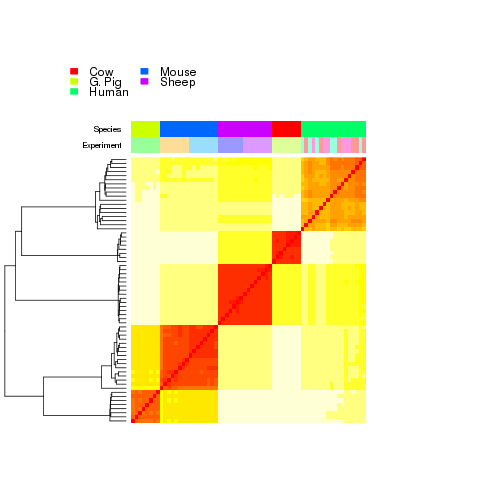

In [382]:
%%R
my_plot_heatmap(adf.jdm, adf.classes)

 [1] Cow Rumen DNA                       Cow Rumen DNA                      
 [3] Cow Rumen DNA                       Cow Rumen DNA                      
 [5] Cow Rumen DNA                       Cow Rumen DNA                      
 [7] Cow Rumen DNA                       Cow Rumen DNA                      
 [9] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
[11] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
[13] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
[15] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
[17] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
[19] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
[21] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
[23] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
[25] HMP Anterior Nares DNA              HMP Anterior Nares DNA             

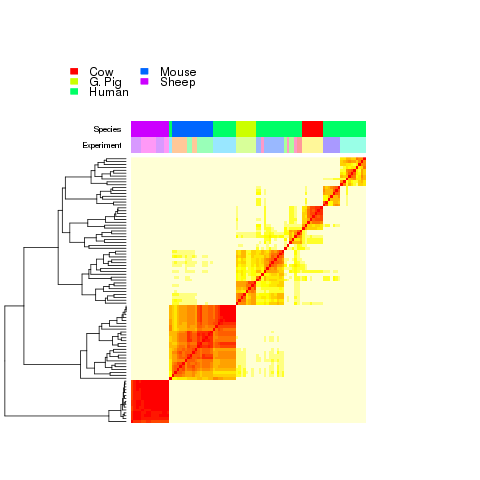

In [386]:
%%R

m.jdm <- make_jsd_matrix(mphlan)
print(m.classes)
print(dim(mphlan))
my_plot_heatmap(m.jdm,m.classes)

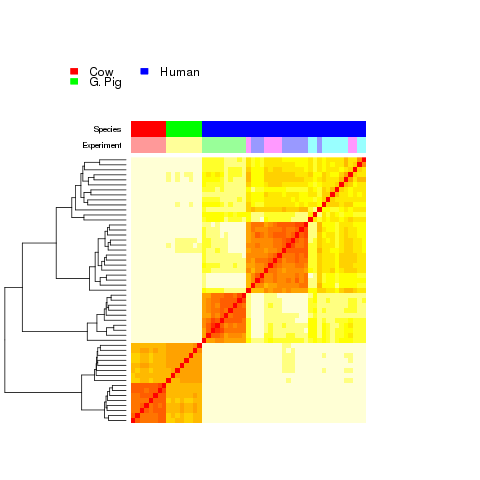

In [384]:
%%R

k.jdm <- make_jsd_matrix(kraken)
my_plot_heatmap(k.jdm,k.classes)

In [385]:
%%R

ad.jdm <- make_jsd_matrix(acdmnd)
heatmap(ad.jdm)


Error in n[, i] : subscript out of bounds
